In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys
import random
from colorama import Fore, Style

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"


In [ ]:
train_df = pd.read_csv("/content/Corona_NLP_train.csv",encoding="latin-1")
test_df = pd.read_csv("/content/Corona_NLP_test.csv",encoding="latin-1")
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
31089,34888,79840,Lagos,06-04-2020,Without the there would not be any problem wh...,Neutral
35564,39363,84315,NaN,09-04-2020,Rice &amp; wheat prices surge amid fears Covid...,Extremely Negative
144,3943,48895,NaN,16-03-2020,When the government says to start social dista...,Positive
8202,12001,56953,irlande du nord,19-03-2020,What the shops are doing is obeying the law of...,Positive
31720,35519,80471,"Zaria, Nigeria",07-04-2020,Kaduna State Task Force on Covid 19 led by the...,Negative


In [ ]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
train_df_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 31089 to 15795
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


In [ ]:
train_df_shuffled.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
train_df_shuffled.duplicated().sum()

0

In [ ]:
train_df_shuffled['Sentiment'].unique()

array(['Neutral', 'Extremely Negative', 'Positive', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
# Filter out rows with 'Neutral' sentiment
train_df_shuffled = train_df_shuffled[train_df_shuffled['Sentiment'] != 'Neutral']

In [ ]:
train_df_shuffled['Sentiment'].unique()

array(['Extremely Negative', 'Positive', 'Negative', 'Extremely Positive'],
      dtype=object)

In [ ]:
train_df_shuffled['Sentiment'].isnull().sum()

0

In [ ]:
# Filter out rows with 'Neutral' sentiment
train_df_shuffled = train_df_shuffled[train_df['Sentiment'] != 'Neutral']

# Remove  whitespace from the 'Sentiment' column
train_df_shuffled['Sentiment'] = train_df_shuffled['Sentiment'].str.strip()

# Define the mapping dictionary for Sentiment categories (excluding 'Neutral')
sentiment_map = {
    'Positive': 1,
    'Extremely Negative': 0,
    'Negative': 0,
    'Extremely Positive': 1
}


train_df_shuffled['Sentiment'] = train_df_shuffled['Sentiment'].map(sentiment_map)


print(train_df_shuffled['Sentiment'].isnull().sum())




0


In [ ]:
# Display the unique values in the 'Sentiment' column
print(train_df_shuffled['Sentiment'].unique())


[0 1]


In [ ]:
# Filter out rows with 'Neutral' sentiment
test_df = test_df[test_df['Sentiment'] != 'Neutral']
# Remove  whitespace from the 'Sentiment' column
test_df['Sentiment'] = test_df['Sentiment'].str.strip()

# Define the mapping dictionary for Sentiment categories (excluding 'Neutral')
sentiment_map = {
    'Positive': 1,
    'Extremely Negative': 0,
    'Negative': 0,
    'Extremely Positive': 1
}


test_df['Sentiment'] = test_df['Sentiment'].map(sentiment_map)


print(test_df['Sentiment'].isnull().sum())

0


In [ ]:
# Calculate the total number of examples
total_examples = len(train_df_shuffled)

positive_count = train_df_shuffled['Sentiment'].value_counts().loc[1]
negative_count = train_df_shuffled['Sentiment'].value_counts().loc[0]

# Calculate the percentages for each class
positive_percentage = (positive_count / total_examples) * 100
negative_percentage = (negative_count / total_examples) * 100


print("Number of examples in each class:")
print("Positive (Corona Positive):", positive_count)
print("Negative (Corona Negative):", negative_count)

print("\nPercentage of examples in each class:")
print("Positive (Corona Positive): {:.2f}%".format(positive_percentage))
print("Negative (Corona Negative): {:.2f}%".format(negative_percentage))


Number of examples in each class:
Positive (Corona Positive): 18046
Negative (Corona Negative): 15398

Percentage of examples in each class:
Positive (Corona Positive): 53.96%
Negative (Corona Negative): 46.04%


The dataset contains slightly more examples of class 1 (Positive) than class 0 (Negative). Around  53.96% of the examples are labeled as Positive (Corona Positive), while approximately 46 are labeled as Negative (Corona Negative).

It's fairly balanced too, about 53% positive class (target = 1) and 48% Negative class (target = 0).


In [ ]:
#checking the samples
print(f"Total training samples: {len(train_df_shuffled)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df_shuffled) + len(test_df)}")


Total training samples: 33444
Total test samples: 3179
Total samples: 36623


In [ ]:
pip install colorama


In [ ]:
# Generate a random index not higher than the total number of samples
random_index = random.randint(0, len(train_df) - 5)

# Color codes for positive and negative sentiments
positive_color = Fore.BLUE  # Blue color for positive sentiments
negative_color = Fore.RED    # Red color for negative sentiments

print("Randomly Selected Training Examples:")
print("-------------------------------------")

for idx, row in enumerate(train_df_shuffled[["OriginalTweet", "Sentiment"]][random_index:random_index + 5].itertuples(), 1):
    _, OriginalTweet, Sentiment = row
    sentiment_label = "Positive" if Sentiment > 0 else "Negative"
    sentiment_color = positive_color if Sentiment > 0 else negative_color
    print(f"Example {idx}:")
    print(f"Sentiment: {sentiment_color}{sentiment_label} (Corona {sentiment_label.lower()}){Style.RESET_ALL}")
    print(f"OriginalTweet: {OriginalTweet}\n")


Randomly Selected Training Examples:
-------------------------------------
Example 1:
Sentiment: Negative (Corona negative)
OriginalTweet: Survey: Asian consumer sentiment during the COVID-19 crisis https://t.co/bUaMCD73T2

Example 2:
Sentiment: Positive (Corona positive)



Take precautions with what is delivered.

Example 3:
Sentiment: Negative (Corona negative)


https://t.co/B1VMhGupqB https://t.co/ffvBSNAaxh

Example 4:
Sentiment: Negative (Corona negative)








#morons

Example 5:
Sentiment: Negative (Corona negative)
OriginalTweet: Although I agree that we must avoid hording food and necessities seeing empty shelves at a grocery store triggers something in your mind As a person with disabilities and no car I am limited to buying what I can carry I could only carry 4 days worth of food



**Train Test split**

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["OriginalTweet"].to_numpy(),
                                                                            train_df_shuffled["Sentiment"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility


In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)
print(
    f"Train: {len(train_sentences)} sentences, {len(train_labels)} labels | "
    f"Validation: {len(val_sentences)} sentences, {len(val_labels)} labels"
)

Train: 30099 sentences, 30099 labels | Validation: 3345 sentences, 3345 labels


**Converting text into numbers**

In [ ]:
# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)


In [ ]:
#Testing with sample sentence

sample_sentence = "Feeling grateful for the recovery from COVID-19! #coronapositive"
# Adapt the TextVectorization layer to build the vocabulary and configure it
text_vectorizer.adapt([sample_sentence])

# Tokenize and vectorize the sample sentence
vectorized_sentence = text_vectorizer([sample_sentence])


print("Sample Sentence:", sample_sentence)
print("Vectorized Sentence:", vectorized_sentence.numpy())


Sample Sentence: Feeling grateful for the recovery from COVID-19! #coronapositive
Vectorized Sentence: [[7 4 6 2 3 5 8 9]]


In [ ]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

32

In [ ]:
# custom text vectorization
max_vocab_length = 10000
max_length = 32 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)


In [ ]:
sample_sentence = "Having a great day! Just got my vaccine. #COVIDvaccine #StaySafe"
text_vectorizer.adapt([sample_sentence])

vectorized_sentence = text_vectorizer([sample_sentence])

print("Sample Sentence:", sample_sentence)
print("Vectorized Sentence:", vectorized_sentence.numpy())

Sample Sentence: Having a great day! Just got my vaccine. #COVIDvaccine #StaySafe
Vectorized Sentence: [[ 6 11  7  9  5  8  4  2 10  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]]


Text vectorization is  integer-based and non semantic serves as a basic transformation of text data into numerical form

we need better dence and semantic representation for NLP tasks so we can try the word embeddings.


**Word Embedding**


In [ ]:
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_1")

embedding

In [ ]:
# Test data (sample sequences of integer indices)
test_sequences = tf.constant([[1, 3, 5, 7, 9, 2, 4, 6, 8, 10]], dtype=tf.int32)

# Pass the test data through the embedding layer
embedded_sequences = embedding(test_sequences)

# Print the output
print("Input Sequences:", test_sequences)
print("Embedded Sequences:", embedded_sequences)

Input Sequences: tf.Tensor([[ 1  3  5  7  9  2  4  6  8 10]], shape=(1, 10), dtype=int32)
Embedded Sequences: tf.Tensor(
[[[-0.03343189  0.03001627 -0.00351565 ... -0.00163601 -0.04579363
    0.01461368]
  [-0.04798485  0.03631607  0.01474695 ...  0.01160489 -0.01805406
    0.0306701 ]
  [-0.04310822 -0.01736705  0.00243306 ...  0.03997867 -0.00308212
    0.03500057]
  ...
  [-0.03668422 -0.02214915  0.02496535 ...  0.04237011  0.00140079
   -0.04770628]
  [ 0.04911281 -0.00932353  0.00580145 ...  0.00129197 -0.04780716
   -0.00262153]
  [-0.02282978  0.01436093 -0.03481653 ...  0.03916234 -0.03039074
   -0.00090205]]], shape=(1, 10, 128), dtype=float32)


In [ ]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

Original text:
Starbucks launches first of its kind Global Partner Emergency Relief Programme to support partners in company operated and licensed retail store markets around the world      

Embedded version:


In [ ]:
# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

<tf.Tensor: shape=(1, 32, 128), dtype=float32, numpy=
array([[[-0.03343189,  0.03001627, -0.00351565, ..., -0.00163601,
         -0.04579363,  0.01461368],
        [-0.03343189,  0.03001627, -0.00351565, ..., -0.00163601,
         -0.04579363,  0.01461368],
        [-0.03343189,  0.03001627, -0.00351565, ..., -0.00163601,
         -0.04579363,  0.01461368],
        ...,
        [-0.03537808, -0.02615421,  0.00827674, ..., -0.02252352,
          0.03007105, -0.00550516],
        [-0.03537808, -0.02615421,  0.00827674, ..., -0.02252352,
          0.03007105, -0.00550516],
        [-0.03537808, -0.02615421,  0.00827674, ..., -0.02252352,
          0.03007105, -0.00550516]]], dtype=float32)>

**Modelling:**

**Model_1**

In [ ]:
# Create tokenization and modelling pipeline
model_1 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_1.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
predictions = model_1.predict(val_sentences)

# Calculate accuracy
baseline_accuracy = accuracy_score(val_labels, predictions)

print("Accuracy of model_1 for Baseline model: {:.2f}%".format(baseline_accuracy * 100))

Accuracy of model_1 for Baseline model: 76.50%


In [ ]:
baseline_preds = model_1.predict(val_sentences)

In [ ]:
def calculate_results(y_true, y_pred):

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 76.50224215246637,
 'precision': 0.7847756966499972,
 'recall': 0.7650224215246637,
 'f1': 0.7568216984032906}

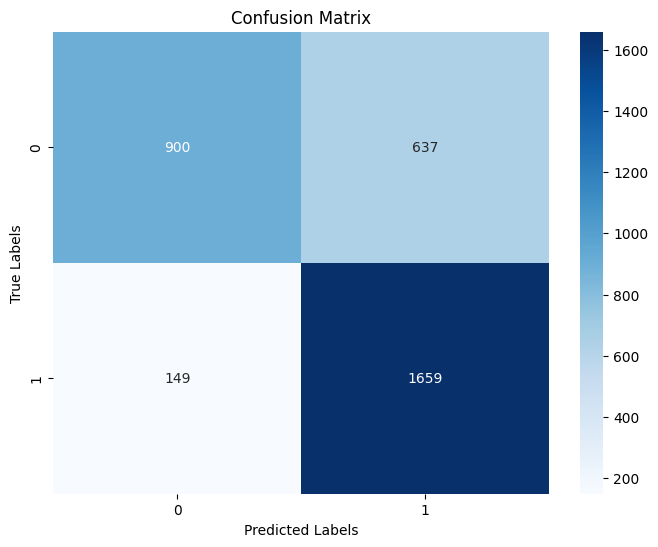

In [ ]:
cm = confusion_matrix(val_labels, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_1.classes_, yticklabels=model_1.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The model seems to have relatively high true positive and true negative values, indicating that it can effectively identify both positive and negative instances.

In [ ]:

def plot_roc_auc(y_true, probabilities, title="ROC Curve"):
    fpr, tpr, thresholds = roc_curve(y_true, probabilities)

    # Calculate the AUC (Area Under the ROC Curve)
    auc_score = roc_auc_score(y_true, probabilities)

    # Find the best threshold and its index
    ix = np.argmax(tpr - fpr)
    best_threshold = thresholds[ix]

    # Create the first plot with both ROC curve and AUC value
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc_score)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Best Threshold = {best_threshold:.2f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')

    # Create the ROC curve plot without markings for the second plot
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, 'b',marker='.', label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - ROC')
    plt.legend()

    plt.tight_layout()
    plt.show()




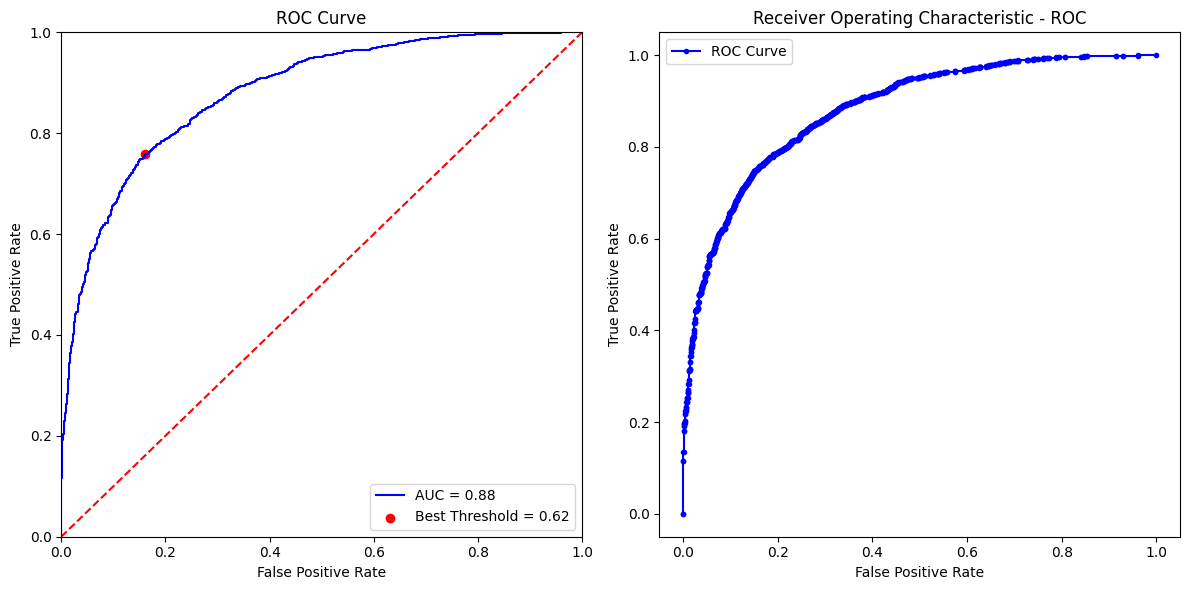

In [ ]:
y_pred_prob = model_1.predict_proba(val_sentences)
y_pred_prob = y_pred_prob[:, 1]

# Use the function to plot both the ROC curve with AUC value and the ROC curve only
plot_roc_auc(val_labels, y_pred_prob)

The AUC score of 0.88 tells us that the model is good at distinguishing between positive and negative cases. It can accurately identify positive instances as positive and negative instances as negative.

The optimal threshold of 0.60 means that the model makes its predictions in a balanced way when it believes there is a 60% chance or higher that a sample is positive. This threshold helps the model achieve a good balance between correctly identifying positive cases and avoiding false positives.

In summary, the model is performing well in separating the two classes, and it makes balanced predictions when it's around 60% confident that a sample is positive.

**Model_2**

In [155]:
# creating a dense model


# Maximum sequence length
max_length = 32

# Define the TextVectorization layer
text_vectorizer = layers.TextVectorization(max_tokens=None,
                                           standardize="lower_and_strip_punctuation",
                                           split="whitespace",
                                           output_mode="int",
                                           output_sequence_length=max_length)

# Fit the TextVectorization layer on the training data to build the vocabulary
text_vectorizer.adapt(train_sentences)

# Convert text data to tokenized sequences
train_sequences = text_vectorizer(train_sentences)
val_sequences = text_vectorizer(val_sentences)

# Create the deep model using the functional API
inputs = layers.Input(shape=(max_length,))
embedding = layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()) + 1,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length)(inputs)
x = layers.GlobalAveragePooling1D()(embedding)
output = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=output)


In [156]:
# Compile the model
model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
print(model_2.summary())



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 32, 128)           8749312   
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 8,749,441
Trainable params: 8,749,441
Non-trainable params: 0
_________________________________________________________________
None


In [157]:
# Fit the model on the training data
history = model_2.fit(train_sequences, train_labels,
                    validation_data=(val_sequences, val_labels),
                    epochs=3,
                    verbose=1)

Epoch 1/3
941/941 [==============================] - 216s 228ms/step - loss: 0.5386 - accuracy: 0.7369 - val_loss: 0.4229 - val_accuracy: 0.8188
Epoch 2/3
941/941 [==============================] - 217s 231ms/step - loss: 0.3111 - accuracy: 0.8846 - val_loss: 0.3675 - val_accuracy: 0.8457
Epoch 3/3
941/941 [==============================] - 219s 232ms/step - loss: 0.2069 - accuracy: 0.9287 - val_loss: 0.3709 - val_accuracy: 0.8466


In [158]:
loss, accuracy = model_2.evaluate(val_sequences, val_labels)
print("Validation Accuracy:", accuracy)

105/105 [==============================] - 0s 4ms/step - loss: 0.3709 - accuracy: 0.8466
Validation Accuracy: 0.8466367721557617


**Model_3**

In [ ]:
tf.random.set_seed(42)
vocab_size = text_vectorizer.vocabulary_size()

model_3_embedding = layers.Embedding(input_dim=vocab_size,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
print(x.shape)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_LSTM")

(None, 32, 128)
(None, 32, 64)


In [ ]:
# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_7 (TextV  (None, 32)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 32, 128)           8749184   
                                                                 
 lstm_2 (LSTM)               (None, 32, 64)            49408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                      

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=3,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230725-214034
Epoch 1/3
941/941 [==============================] - 246s 256ms/step - loss: 0.4555 - accuracy: 0.7783 - val_loss: 0.3885 - val_accuracy: 0.8284
Epoch 2/3
941/941 [==============================] - 243s 258ms/step - loss: 0.2119 - accuracy: 0.9174 - val_loss: 0.3879 - val_accuracy: 0.8296
Epoch 3/3
941/941 [==============================] - 247s 262ms/step - loss: 0.1035 - accuracy: 0.9623 - val_loss: 0.5240 - val_accuracy: 0.8164


In [ ]:
# Evaluate the model on the validation data
loss, accuracy = model_3.evaluate(val_sentences, val_labels)

print("Validation Accuracy:", accuracy)

105/105 [==============================] - 2s 23ms/step - loss: 0.5240 - accuracy: 0.8164
Validation Accuracy: 0.8164424300193787


**Model_4**

In [ ]:
#GRU

tf.random.set_seed(42)

model_4_embedding = layers.Embedding(input_dim=vocab_size,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_GRU")

In [ ]:
# Compile GRU model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=3,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230725-210841
Epoch 1/3
941/941 [==============================] - 267s 278ms/step - loss: 0.4720 - accuracy: 0.7632 - val_loss: 0.3555 - val_accuracy: 0.8496
Epoch 2/3
941/941 [==============================] - 273s 290ms/step - loss: 0.2100 - accuracy: 0.9175 - val_loss: 0.3551 - val_accuracy: 0.8475
Epoch 3/3
941/941 [==============================] - 265s 281ms/step - loss: 0.0951 - accuracy: 0.9656 - val_loss: 0.4796 - val_accuracy: 0.8341


In [ ]:
# Evaluate the model on the validation data
loss, accuracy = model_4.evaluate(val_sentences, val_labels)

print("Validation Accuracy:", accuracy)

105/105 [==============================] - 2s 15ms/step - loss: 0.4796 - accuracy: 0.8341
Validation Accuracy: 0.834080696105957


**Model_5**

In [ ]:
#using  transfer learning
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_5 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_5_USE")

# Compile model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=3,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230725-212348
Epoch 1/3
941/941 [==============================] - 23s 21ms/step - loss: 0.5199 - accuracy: 0.7462 - val_loss: 0.4936 - val_accuracy: 0.7629
Epoch 2/3
941/941 [==============================] - 17s 18ms/step - loss: 0.4883 - accuracy: 0.7615 - val_loss: 0.4923 - val_accuracy: 0.7599
Epoch 3/3
941/941 [==============================] - 17s 18ms/step - loss: 0.4795 - accuracy: 0.7667 - val_loss: 0.4845 - val_accuracy: 0.7659


In [ ]:
# Evaluate the model on the validation data
loss, accuracy = model_5.evaluate(val_sentences, val_labels)

print("Validation Accuracy:", accuracy)

105/105 [==============================] - 2s 19ms/step - loss: 0.4845 - accuracy: 0.7659
Validation Accuracy: 0.7659192681312561


In [149]:
# Convert prediction probabilities to labels
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

105/105 [==============================] - 2s 15ms/step


{'accuracy': 0.7659192825112108,
 'precision': 0.766510660426417,
 'recall': 0.8152654867256637,
 'f1_score': 0.7901366925757168}

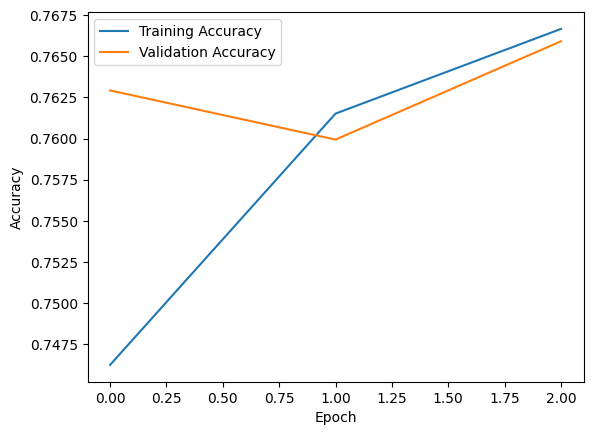

In [ ]:
# Plot training and validation accuracy
plt.plot(model_5_history .history["accuracy"], label="Training Accuracy")
plt.plot(model_5_history .history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Comparing the performance of each of our models**

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
def calculate_results(y_true, y_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate precision, recall, f1-score, and support
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    # Create a dictionary to store the results
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

    return results


In [163]:
model_results = {}

# Model 1
model_1_pred_probs = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_results['Baseline_model'] = calculate_results(val_labels, model_1_preds)

# Model 2
model_2_pred_probs = model_2.predict(val_sequences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_results['Deep_model'] = calculate_results(val_labels, model_2_preds)

# Model 3
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_results['Lstm_model'] = calculate_results(val_labels, model_3_preds)

# Model 4
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_results['Gru_model'] = calculate_results(val_labels, model_4_preds)

# Model 5
model_5_pred_probs = model_5.predict(val_sentences)  # Assuming new_val_sentences for Model 5
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_results['Tl_model'] = calculate_results(val_labels, model_5_preds)


105/105 [==============================] - 2s 16ms/step


In [164]:
results_df = pd.DataFrame(model_results).T
results_df


,accuracy,precision,recall,f1_score
Baseline_model,0.765022,0.722561,0.917588,0.808480
Deep_model,0.846637,0.853246,0.865044,0.859105
Lstm_model,0.816442,0.876419,0.768805,0.819093
Gru_model,0.834081,0.887926,0.793142,0.837862
Tl_model,0.765919,0.766511,0.815265,0.790137


Conclusion:

Based on these insights, the Deep Model seems to be the best performing one, as it achieves the highest accuracy, precision, recall, and F1-score. The deep model strikes a good balance between precision and recall, making it the most effective model for this particular task.